# WaveMap spike profiles test 2

purpose: cluster units based on six channel spike profile  

method: 
 - aligned templates on trough (maximal negative peak) before applying wavemap

pros:
- sites are colocated in a local neighborhood as expected

TODO: 
- try average everywhere (like Paulk) instead of median 

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor
import sklearn.preprocessing
import os
import random
from umap import umap_ as umap
import networkx as nx
import community as community_louvain
import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.postpro import waveform

# SETUP PARAMETERS
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms

# silico
data_conf_sili, param_conf_sili = get_config("vivo_marques", "c26").values()
RAW_PATH_sili = data_conf_sili["recording"]["input"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
STUDY_FOLDER_sili = data_conf_sili["postprocessing"]["waveform"]["sorted"]["for_wavemap"]["study"]
SORTED_sili = data_conf_sili["sorting"]["sorters"]["kilosort3"]["output"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
LINEWIDTH = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
tight_layout_cfg = {"pad": 0.1}

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back

2024-02-08 15:11:00,172 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-08 15:11:00,185 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Build spike instances for wavemap with the units with the 5 typical profiles

In [2]:
# takes 0.4 secs
# load stuffs
Recording = si.load_extractor(PREP_PATH_sili)

# load waveforms
WaveformExtractor = waveform.load(
    Recording,
    study_folder=STUDY_FOLDER_sili,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

# number of waveform samples
nsamples = WaveformExtractor.nsamples

In [3]:
# takes 0.8 secs
def get_unit_largest_templates_parallelized(dummy, cell_id: int):
    """get each unit six largest templates
    Args:
        cell_id (int): unit id

    Returns:
        (dict):
        - "templates": unit's six largest templates stacked into a single row vector
        - "sites": associated sites
    """
    # set parameters
    N_SPIKES = 6
    N_SITES = 384

    # get waveforms
    wfs = WaveformExtractor.get_waveforms(cell_id)

    # get this unit's templates per site
    site_templates = []
    peak_to_peak_amps = []
    for site in range(N_SITES):

        # calculate template
        template = np.mean(wfs[:, :, site].T, axis=1)

        # calculate peak-to-peak amplitude
        peak_to_peak_amps.append(max(template) - min(template))
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get six largest median spikes (templates) and concatenate
    # into a single row vector for UMAP
    descend_sort_ix = np.argsort(peak_to_peak_amps)[::-1]

    # order associated sites
    ordered_sites = np.arange(0, N_SITES, 1)[descend_sort_ix]
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]].T.flatten()
    return {"templates": unit_i_spike, "sites": ordered_sites}


def plot_site_coords(selected_unit: int, ordered_sites, Recording):

    # show 6 largest sites for selected unit
    largest_sites = ordered_sites[selected_unit][:6]
    print("ordered sites:", largest_sites)

    Probe = Recording.get_probe()

    # plot file contact with ids
    fig, ax = plt.subplots(1, 1, figsize=(4, 10))
    ax.plot(
        Probe.contact_positions[:, 0],
        Probe.contact_positions[:, 1],
        "o",
        markerfacecolor="w",
        color="k",
        markersize=5,
    )

    coord2 = Probe.contact_positions[np.array(largest_sites), :]

    # plot file contact with ids
    ax.plot(
        coord2[:, 0],
        coord2[:, 1],
        "o",
        markerfacecolor="r",
        color="k",
        markersize=5,
    )
    for ix in range(len(coord2)):
        if ix % 1 == 0:
            ax.text(
                coord2[ix, 0],
                coord2[ix, 1] - 100,
                "%s" % (str(largest_sites[ix])),
                size=6,
                zorder=100,
                color="r",
            )
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)

In [4]:
# curate single units (postprocessing)
Sorting = si.load_extractor(SORTED_sili)

# list sorted single units
single_units = Sorting.get_property("KSLabel") == "good"
single_units = WaveformExtractor.unit_ids[single_units]

### Create WaveMap waveform dataset

In [5]:
# takes 3 min for the 227 single units (KSLabel)
# takes 8 mins for all (1310) units
# compute unit's six largest templates
# (parallelized over units)
with ProcessPoolExecutor() as executor:
    site_templates = executor.map(
        get_unit_largest_templates_parallelized,
        np.arange(0, len(single_units), 1),  # dummy, not used
        single_units,
    )

# collect
site_templates = list(site_templates)

# format for wavemap (templates x (6 sites x ntimepoints))
site_templates_all = []
sites = []
for ix in range(len(single_units)):
    site_templates_all.append(site_templates[ix]["templates"].tolist())
    sites.append(site_templates[ix]["sites"].tolist())
templates_for_wavemap = np.array(site_templates_all)

print(templates_for_wavemap.shape)

(227, 2160)


### Check site locations

The sites with largest amplitudes always form a neighborhood.

ordered sites: [1, 0, 3, 5, 2, 4]


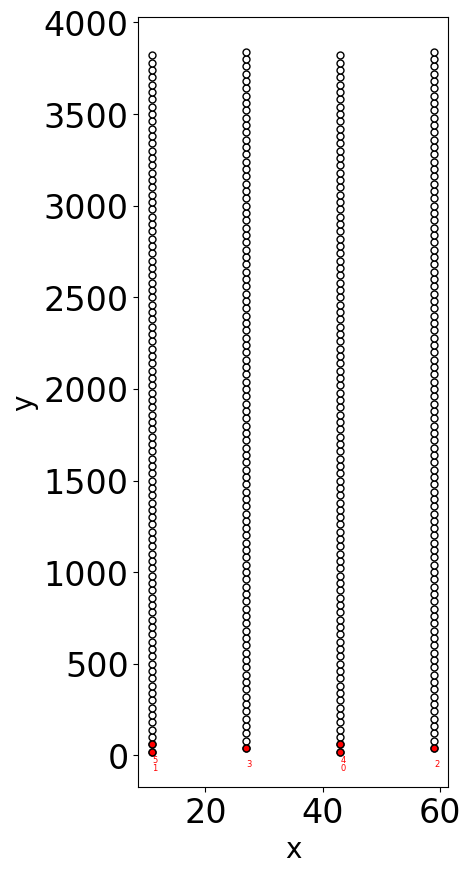

In [6]:
SELECTED_UNIT = 0

plot_site_coords(SELECTED_UNIT, sites, Recording)

#### Align template troughs

In [7]:
ALIGNED_MAX_AFTER = 100  # 2.25 ms after
ALIGNED_MAX_BEFORE = 100  # 2.25 ms msec before

n_sites_for_umap = int(templates_for_wavemap.shape[1] / nsamples)

# isolate each unit's largest template
largest_templates = templates_for_wavemap[:, :nsamples]

aligned_temps = []

for ix in range(len(single_units)):

    # find trough
    ix_trough = np.argmin(largest_templates[ix, :])

    # align the templates for each site
    # to the location of the first positive peak of
    # the largest template
    templates_unit_i = []
    for jx in range(n_sites_for_umap):

        # align to the first positive peak
        try:
            templates_unit_i.append(
                templates_for_wavemap[
                    ix,
                    jx * nsamples
                    + ix_trough
                    - ALIGNED_MAX_BEFORE : jx * nsamples
                    + ix_trough
                    + ALIGNED_MAX_AFTER,
                ]
            )
        except:
            print("reduce the length of the preceding and following periods")

    # re-concatenate into a single row vector
    templates_unit_i = np.array(templates_unit_i).flatten()
    aligned_temps.append(templates_unit_i)

aligned_temps = np.array(aligned_temps)

# sanity check
assert all(np.sum(aligned_temps, axis=1)), "some voltages are nan"

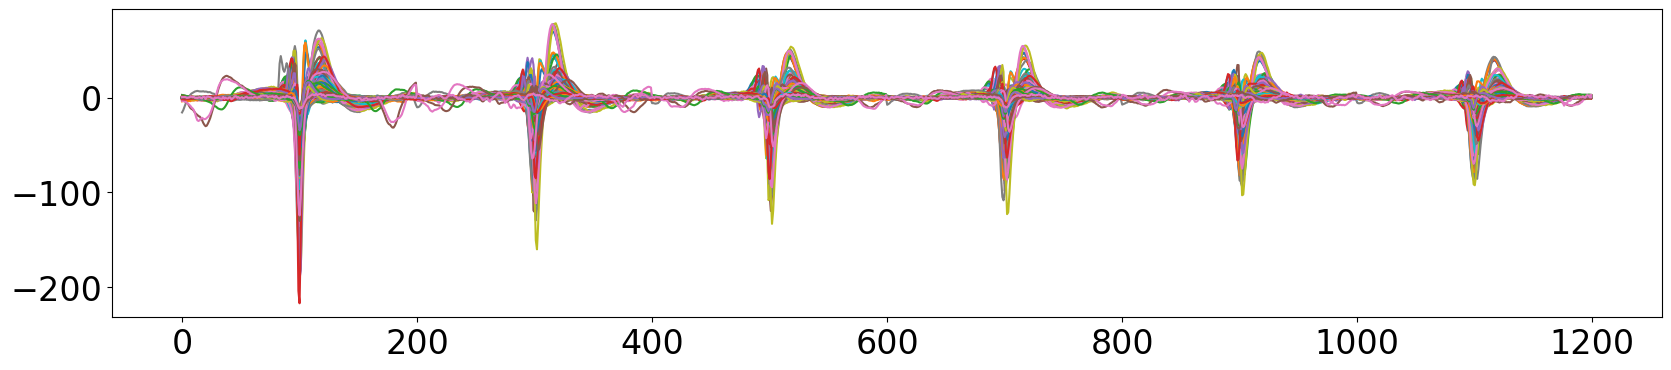

In [8]:
# plot all single units
plt.subplots(1, 1, figsize=(20, 4))
plt.plot(aligned_temps.T)

### WaveMap clustering

In [9]:
# takes 13 secs
SPIKE_PERIOD = int(
    aligned_temps.shape[1] / n_sites_for_umap
)  # in timepoints (6 ms at 40KHz)
RAND_STATE = 42  # 42

# normalize waveform amplitudes between 0 and 1.
normWFs = sklearn.preprocessing.normalize(aligned_temps, norm="max")

# reduce waveform dimensionality with UMAP
np.random.seed(RAND_STATE)
os.environ["PYTHONHASHSEED"] = str(RAND_STATE)
random.seed(RAND_STATE)
reducer = umap.UMAP()
mapper = reducer.fit(normWFs)

# clustering with Louvain
G = nx.from_scipy_sparse_array(mapper.graph_)
clustering = community_louvain.best_partition(G)
clustering_solution = list(clustering.values())

# create 2D embedding
embedding = reducer.fit_transform(normWFs)

# get cluster profiles
umap_df = pd.DataFrame(embedding, columns=("x", "y"))
umap_df["waveform"] = list(normWFs)
umap_df["cluster_id"] = clustering_solution

profiles = np.unique(umap_df["cluster_id"])

### Plot embedding

profile (count): 6
profiles: [0 1 2 3 4 5]


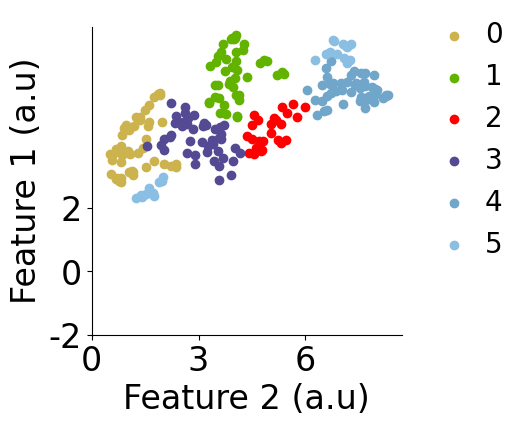

In [10]:
# set profile colors
colors = np.array(
    [
        [0.8, 0.7, 0.3],  # yellow/gold
        [0.38, 0.70, 0],  # green
        [1, 0, 0],  # red
        [0.33, 0.29, 0.58],  # purple blue
        [0.44, 0.65, 0.79],  # light blue
        [0.54, 0.75, 0.89],  # lighter blue
        # [254 / 255, 235 / 255, 226 / 255],  # purple variation
        # [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
        [247 / 255, 104 / 255, 161 / 255],  # purple variation
        [221 / 255, 52 / 255, 151 / 255],  # purple variation
        [174 / 255, 1 / 255, 126 / 255],  # purple variation
    ]
)

colors_mean = np.array(
    [
        [0.6, 0.54, 0.27],  # yellow/gold
        [0.1, 0.5, 0],  # green
        [0.9, 0, 0],  # red
        [0.1, 0, 0.38],  # purple blue
        [0.24, 0.45, 0.59],  # light blue
        [0.34, 0.55, 0.69],  # lighter blue
        # [254 / 255, 235 / 255, 226 / 255],  # purple variation
        # [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
        [247 / 255, 104 / 255, 161 / 255],  # purple variation
        [221 / 255, 52 / 255, 151 / 255],  # purple variation
        [174 / 255, 1 / 255, 126 / 255],  # purple variation
    ]
)

# plot embedding
f, ax = plt.subplots(1, figsize=FIG_SIZE)
for ix, profile_i in enumerate(profiles):
    ax.scatter(
        umap_df["x"][umap_df["cluster_id"] == profile_i].tolist(),
        umap_df["y"][umap_df["cluster_id"] == profile_i].tolist(),
        marker="o",
        color=colors[ix],
        label=profile_i,
    )

# legend
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Feature 1 (a.u)")
ax.set_xlabel("Feature 2 (a.u)")
ax.set_xticks([0, 3, 6])
ax.set_xticklabels([0, 3, 6])
ax.set_yticks([-2, 0, 2])
ax.set_yticklabels([-2, 0, 2])
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.1), **legend_cfg)

# print cluster profiles
print("profile (count):", len(np.unique(umap_df["cluster_id"])))
print("profiles:", profiles)

# # save fig
# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/pdf/marques/marques_silico_WaveMap_embedding.pdf",
#     **savefig_cfg,
# )
# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/svg/marques/marques_silico_WaveMap_embedding.svg",
#     **savefig_cfg,
# )

### Plot same as fig3 Paulk Nat Neurosci 2022

- first site (column) is the site with the largest peak to peak amplitude
- Second site (column) is the site with the£ second largest peak to peak amplitude

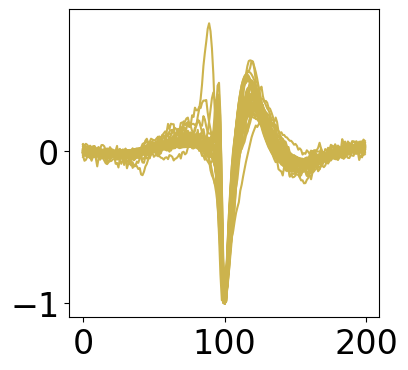

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

# site 1
profile_i = 0
template = normWFs[umap_df["cluster_id"] == profile_i, :SPIKE_PERIOD].T

# plot
axes.plot(
    template,
    color=colors[profile_i],
)

2024-02-08 15:17:00,782 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-02-08 15:17:00,834 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-02-08 15:17:00,881 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-02-08 15:17:00,941 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-02-08 15:17

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquita

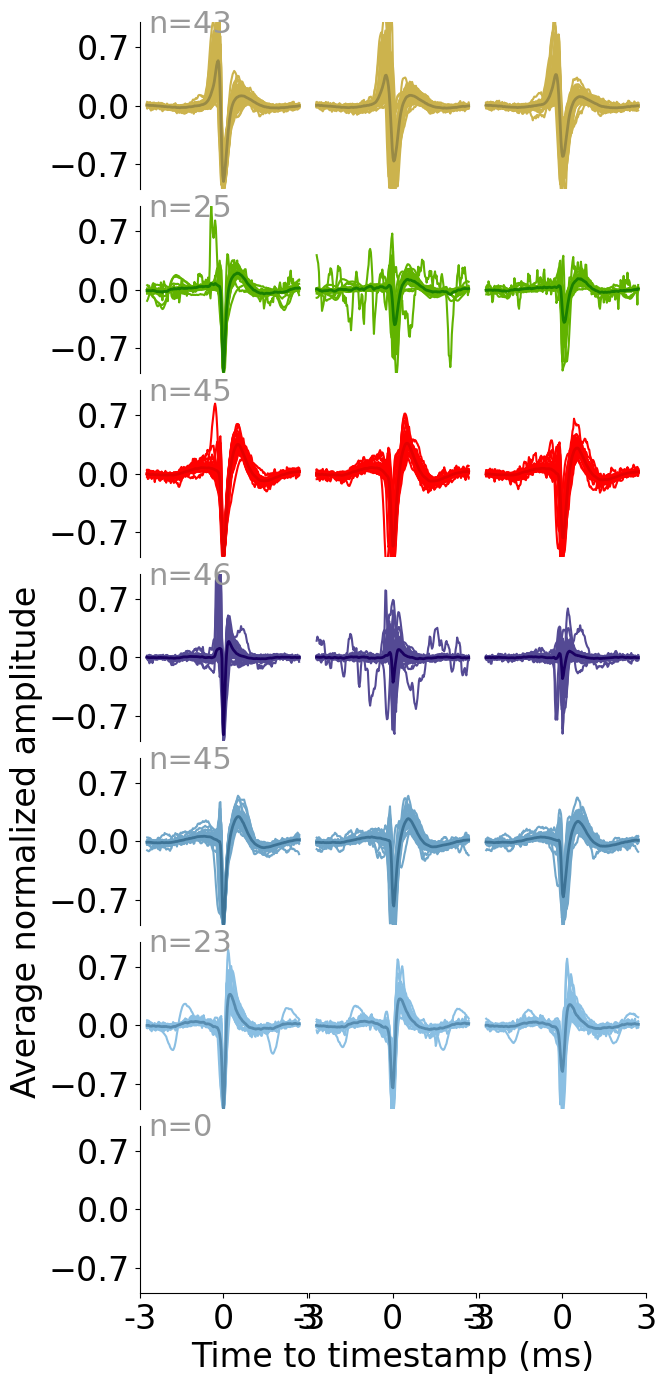

In [14]:
# takes 2 secs

from collections import Counter

counts = Counter(umap_df["cluster_id"])

# order cluster profile panels
profiles = [1, 2, 0, 4, 3, 5, 6]

# spike timestamp locatoon
timestamp_timepoint = SPIKE_PERIOD / 2

# setup figure
fig, axes = plt.subplots(len(profiles), 3, figsize=(5 * 1.5, 11 * 1.5))

for ix, profile_i in enumerate(profiles):

    # site 1
    # unit templates
    axes[ix, 0].plot(
        normWFs[umap_df["cluster_id"] == profile_i, :SPIKE_PERIOD].T,
        color=colors[ix],
    )
    # average over units
    axes[ix, 0].plot(
        np.mean(normWFs[umap_df["cluster_id"] == profile_i, :SPIKE_PERIOD].T, axis=1),
        color=colors_mean[ix],
        linewidth=2,
    )
    axes[ix, 0].set_box_aspect(1)  # square axis
    axes[ix, 0].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 0].legend(frameon=False)
    axes[ix, 0].annotate(
        "n=" + str(counts[profile_i]),
        xy=(0.05, 0.9),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="bottom",
        color=(0.6, 0.6, 0.6),
        fontsize=22,
    )
    axes[ix, 0].set_yticks([-0.7, 0, 0.7])
    axes[ix, 0].set_ylim([-1, 1])

    if ix == 4:
        axes[ix, 0].set_ylabel("Average normalized amplitude")
    axes[ix, 0].set_xticks([])
    axes[ix, 0].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 0].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 0].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])

    # site 2
    axes[ix, 1].plot(
        normWFs[umap_df["cluster_id"] == profile_i, SPIKE_PERIOD : 2 * SPIKE_PERIOD].T,
        color=colors[ix],
    )
    # average over units
    axes[ix, 1].plot(
        np.mean(
            normWFs[
                umap_df["cluster_id"] == profile_i, SPIKE_PERIOD : 2 * SPIKE_PERIOD
            ].T,
            axis=1,
        ),
        color=colors_mean[ix],
        linewidth=2,
    )
    axes[ix, 1].set_box_aspect(1)  # square axis$
    axes[ix, 1].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticks([-0.7, 0, 0.7])
    axes[ix, 1].set_ylim([-0.9, 0.9])
    axes[ix, 1].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 1].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticklabels([])
    axes[ix, 1].set_yticks([])
    axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 1].set_xticks([])
    axes[ix, 1].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
        axes[ix, 1].set_xlabel("Time to timestamp (ms)")

    # site 3
    axes[ix, 2].plot(
        normWFs[
            umap_df["cluster_id"] == profile_i, 2 * SPIKE_PERIOD : 3 * SPIKE_PERIOD
        ].T,
        color=colors[ix],
    )
    # average over units
    axes[ix, 2].plot(
        np.mean(
            normWFs[
                umap_df["cluster_id"] == profile_i, 2 * SPIKE_PERIOD : 3 * SPIKE_PERIOD
            ].T,
            axis=1,
        ),
        color=colors_mean[ix],
        linewidth=2,
    )
    axes[ix, 2].set_box_aspect(1)  # square axis
    axes[ix, 2].set_yticks([-0.7, 0, 0.7])
    axes[ix, 2].set_ylim([-0.9, 0.9])
    axes[ix, 2].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 2].spines[["bottom"]].set_visible(False)
    axes[ix, 2].set_yticklabels([])
    axes[ix, 2].set_yticks([])
    axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].set_xticks([])
    axes[ix, 2].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])

# fig.tight_layout(**tight_layout_cfg)
fig.subplots_adjust(wspace=-0.3, hspace=0.1)

# # save fig
# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/pdf/marques/marques_vivo_spike_shape.pdf",
#     **savefig_cfg,
# )
# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/svg/marques/marques_vivo_spike_shape.svg",
#     **savefig_cfg,
# )